# Valoración de Títulos

**Autor:   Juan José Triviño Zambrano**  
**Fecha:   Mayo 30, 2020**


Valorar un instrumento financiero es un proceso que lo realizan por lo general los analistas financieros solamente, pues es una técnica que aunque no es dificil de implementarla, esta lejos del conocimiento del común de los inversores. Es más, los analistas persé pueden encontrar dificultades/complicaciones a la hora de analizar estos instrumentos, ya que es muy común utilizar herramientas ortodoxas en donde el manejo de la información es demasiado manual, generando complicaciones y/o errores en el proceso.

En este documento crearé un sistema automatizado utilizando **Python** en conjunto con sus potentes librerías de análisis de datos y visualización gráfica, entre otras, que resuelva el análisis de títulos de inversión en cuestión de segundos.

## Fuente de la información
### Bolsa de Valores de Guayaquil

La Bolsa de Valores de Guayaquil a través de su [sitio web](https://www.bolsadevaloresguayaquil.com/valoracion/index.asp), en el apartado de valoración información referente a títulos de renta fija y renta variable. No es la mejor forma de presentar la información(a través de hojas de cálculo), que en sí denota la falta de técnica en la publicación de la información, hay que decir que esta forma anticuada la viene realizando desde el año 2006 sin que en todos estos años, hayan inovado o mejorado la forma de proporcionar la información a sus usuarios/clientes. Aún así, "es lo que hay" y se le puede sacar provecho de alguna manera.

La información viene presentada en dos vertientes:
1. **Diaria:** Que regoge la información diaria de los títulos, la cuál solo está disponible en su último día, actualizándose cada dia laborable.
2. **Histórica:** Que recoge la información de forma trimestral, para cual existe un directorio para todo su historial desde el año 2006.

## Echando mano al código
### Descargando los archivos desde el directorio web
Nos vamos a centrar ahora en descargar todo a esa información `Histórica` y lo haremos no de la forma ortodoxa que casi todo el mundo haría, sino que diseñaremos una función para que haga el trabajo por nosotros.
Además de descargarlos, la diseñaremos para que le de un formato más adecuado al nombre del archivo `(aa-mm-dd)`, para que este mejor ordenado y tengan un formato de fecha conforme lo exigen los estándares.

In [1]:
from bs4 import BeautifulSoup
import requests
import re

In [2]:
def descargar_archivos():
    url = "https://www.bolsadevaloresguayaquil.com/valoracion/Historico/"
    codigo_html = requests.get(url).text
    web = BeautifulSoup(codigo_html, "lxml")
    links = web.find_all('a')
    url_links = [url[:39] + links[href].get('href') for href in range(1,len(links))]
    meses = {'Enero':'01', 'Febrero':'02', 'Marzo':'03', 'Abril':'04', 'Mayo':'05', 'Junio':'06',
             'Julio':'07', 'Agosto':'08', 'Septiembre':'09', 'Octubre':'10', 'Noviembre':'11', 'Diciembre':'12'}   
    for url in url_links:
        idx = url.rfind('/')
        nombre_ini = url[idx+1:]
        lista = re.findall('\d+|\D+', nombre_ini)
        if len(lista) == 4:
            nombre_fin = f'{lista[2]}-{meses[lista[1]]}-{lista[0]}{lista[3]}'
            resp = requests.get(url)
            with open(nombre_fin, 'wb') as output:
                output.write(resp.content)

## Operaciones con los datos extraídos
Ya con la data disponible, se podría hacer un modelado dinámico, ya que tenemos información a través del tiempo, con lo cual armar sin problemas un panel de datos donde la librería `pandas` es una herramienta muy poderosa, de hecho su nombre deriva de '*panel data*'. Pero dejaremos ese trabajo para otra ocasión, en un posterior análisis.

Por esta vez nos vamos a concentrar en analizar la información contenida en un solo fichero de datos, para lo cual necesitamos extraer la información relevante que vamos a utilizar.

Uno de los problemas(de los tantos) de las hojas de cálculo, es que la información puede venir 'desorganizada y sucia'. No hay problema, diseñaremos una función que nos permita extraer la data relevante para nuestro análisis, descartando la información que no vayamos a utilizar.

Lo primero será importar la librerias que vamos a necesitar:

In [1]:
import numpy as np
import pandas as pd
import sympy as sym
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

### Extrayendo los datos de un archivo
Dentro del proceso de valoración descrito en el [Manual Operativo](https://www.bolsadevaloresguayaquil.com/valoracion/vectores/res_cnv_003_2005.pdf) para la valoración a precios de mercado, publicado por el Consejo Nacional de Valores, se indica que estos instrumentos tienen que ser categorizados de acuerdo a sus características intrínsecas:
- Clase;
- Calificación;
- Tipo de tasa;
- Moneda; y,
- Días a vencimiento

Considerando que el tipo de tasa es fija, que la moneda también es fija y que los días a vencimiento es la variable explicativa que vamos a trabajar, entonces la categorización ha de hacerse bajo los parámetros de clase y calificación de riesgo.

#### Clase de título 
Los parámetros asignados a la agrupación por clase de título son los siguientes:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-kq0l{background-color:#38fff8;border-color:inherit;font-weight:bold;text-align:center;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr> 
    <th class="tg-kq0l">Código</th>
    <th class="tg-kq0l">Clase</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-c3ow">00001</td>
    <td class="tg-c3ow">Min. Fin. / Bco. Central</td>
  </tr>
  <tr>
    <td class="tg-c3ow">00002</td>
    <td class="tg-c3ow">Otros sector público</td>
  </tr>
  <tr>
    <td class="tg-c3ow">00003</td>
    <td class="tg-c3ow">Sector privado financiero</td>
  </tr>
  <tr>
    <td class="tg-c3ow">00004</td>
    <td class="tg-c3ow">Sector privado no financiero</td>
  </tr>
  <tr>
    <td class="tg-c3ow">00005</td>
    <td class="tg-c3ow">Multilaterales y supranacionales</td>
  </tr>
</tbody>
</table>

#### Calificación de Riesgo
Los parámetros asignados a la agrupación por calificación de riesgo son los siguientes:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-style:solid;border-width:0px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;
  padding:10px 5px;word-break:normal;}
.tg th{border-style:solid;border-width:0px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-kq0l{background-color:#38fff8;border-color:inherit;font-weight:bold;text-align:center;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-kq0l">Código</th>
    <th class="tg-kq0l">Clase</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-c3ow">00001</td>
    <td class="tg-c3ow">Min. Fin. / Bco. Central</td>
  </tr>
  <tr>
    <td class="tg-c3ow">00002</td>
    <td class="tg-c3ow">Otros sector público</td>
  </tr>
  <tr>
    <td class="tg-c3ow">00003</td>
    <td class="tg-c3ow">Sector privado financiero</td>
  </tr>
  <tr>
    <td class="tg-c3ow">00004</td>
    <td class="tg-c3ow">Sector privado no financiero</td>
  </tr>
  <tr>
    <td class="tg-c3ow">00005</td>
    <td class="tg-c3ow">Multilaterales y supranacionales</td>
  </tr>
</tbody>
</table>

Dado lo anterior, se necesitará crear una función que permita extraer los datos considerando los filtros indicados.
Por defecto seleccionaremos los que sean del sector privado financiero(Obligaciones y que pertenezcan a la categoría más alta de calificación de riesgo. Aunque esto es perfectamente parametrizable.

In [281]:
def extraer_datos(archivo, calificacion, titulo):
    """
    Extrae los datos de Plazo al vencimiento y Tasa nominal equibvalente desde un fichero excel

    Parameters
    ----------
    archivo : str
        Nombre o ruta donde se encuentra alojado el archivo
    calificacion : list-like
        Calificación o categoría de calificaciones de riesgo
    titulo : str
        Clase de titulo dada la naturaleza de su emisor
        
    Returns
    -------
    plazo_rend: DataFrame
        Compuesto de tiempo para ek vencimiento y su tasa nominal

    """
    df = pd.read_excel(archivo, header = 6, index_col=0)
    df.dropna(how='all', inplace=True)
    df = df.loc[df.index.dropna()]
    df.index=df.index.astype(int)
    homogeneos = df[(df['CALIFICACION'].isin(calificacion)) & (df['TITULO'].str.contains(titulo))]
    plazo_rend = homogeneos[['PLAZO POR VENCER', 'TASA NOMINAL EQUIVALENTE %']]
    plazo_rend.sort_values('PLAZO POR VENCER', inplace=True)
    return plazo_rend

#### Tabla de Calificaciones
Generamos una tabla de datos con las calificaciones categorizadas según lo visto anteriormente, para luego hacer uso de ella seleccionando las categorías que vayamos a analizar.

In [237]:
cal = {'Codigo':['01000','02000', '03000','04000', '05000'], 'Calificacion': [["AAA+", "AAA", "AAA-"],\
                                                                        ["AA+", "AA", "AA-"],\
                                                                        ["A+", "A"," A-"],\
                                                                        ["BBB+", "BBB", "BBB-"],\
                                                                        ["C", "D", "E"]]}
tabla_calificaciones = pd.DataFrame(cal).set_index('Codigo')
tabla_calificaciones

,Calificacion
Codigo,
01000,"[AAA+, AAA, AAA-]"
02000,"[AA+, AA, AA-]"
03000,"[A+, A, A-]"
04000,"[BBB+, BBB, BBB-]"
05000,"[C, D, E]"


In [288]:
# Extrayendo las calificaciones según categoría escogida
from pandas.core.common import flatten
categorias_seleccionadas = ['01000']
calificaciones_seleccionadas = tabla_calificaciones.loc[categorias_seleccionadas].values

# Parámetros
archivo = 'archivos/20-04-30.xls'
calificaciones = list(flatten(calificaciones_seleccionadas))
tipo = "OBLIGACIONES"

#### Demostración de la función

In [289]:
datos = extraer_datos(archivo, calificacion=calificaciones, titulo=tipo)
datos

,PLAZO POR VENCER,TASA NOMINAL EQUIVALENTE %
278,371.0,6.685069
90,397.0,6.290200
834,405.0,6.336718
778,408.0,6.353914
56,412.0,6.376635
...,...,...
267,2127.0,7.543234
113,2133.0,7.548182
880,2160.0,7.570212
284,2364.0,7.675633


La tabla anterior contiene los datos de plazo al vencimiento y tasa nominal equivalente de los títulos, filtrados según lo especificado en la función

## Valoración
### Modelos de regresión 

Es común trabajar con modelos matemáticos para estimar variables en función de otra/s, los modelos de regresión más comunes son:

\begin{aligned}
Modelo\:lineal :\: &\large r = \beta_0 + \beta_1 t + \epsilon \\
Modelo\:lin-log :\:  &\large r = \beta_0 + \beta_1 \ln(t) + \epsilon
\end{aligned}

donde:
- r = Rendimiento esperado del título
- t = Tiempo al vencimiento del título

Ahora una función que me permita correr estas dos regresiones:

In [290]:
def regresiones(datos):
    r = datos['TASA NOMINAL EQUIVALENTE %']
    t = datos['PLAZO POR VENCER']
    # Elimino valores extremos que se salen de los limites de control(outliers)
    datos = datos[r.isin(r[r.between(r.quantile(.025), r.quantile(0.975))])]
    datos = datos[t.isin(t[t.between(t.quantile(.025), t.quantile(0.95))])]
    # Actualizar los datos
    r = datos['TASA NOMINAL EQUIVALENTE %']
    t = datos['PLAZO POR VENCER']
    # Correr las regresiones
    reg_lin = stats.linregress(t, r)
    reg_log = stats.linregress(np.log(t), r)  
    # Generar las gráficas
    plt.figure(figsize=(12,6))
    plt.plot(t, r, 'o', label='Datos')
    plt.plot(t, reg_lin[0]*t + reg_lin[1], 'r',
             label=f'${round(reg_lin[0],3)}t+{round(reg_lin[1], 3)};\
             ;R^{2}={round(reg_lin[2]**2,4)}$')
    plt.plot(t, reg_log[0]*np.log(t) + reg_log[1], 'g',
             label=f'${round(reg_log[0],3)}\cdot ln(t){round(reg_log[1], 3)};\
             ;R^{2}={round(reg_log[2]**2,4)}$')
    plt.legend()
    plt.show()

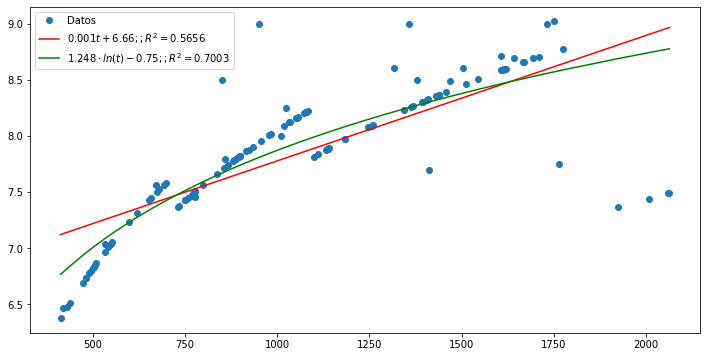

In [291]:
regresiones(datos)

### Modelo de regresión log-lin-log
Este es el modelo que utiliza la BVG para ajustar la curva de rendimientos en sus informes:

$$\large \ln(1+r)=\beta_{0}+\beta_{1}t+\beta_{2}\ln(t)$$

A decir verdad no conocía este modelo econométrico, vamos que noy economista, provengo de Administración de Empresas, me he puesto a investigar, no encontré nada por cierto. Aún asi, pude programar la función ya que no deja de ser un modelo matemático.

PD: Lo de log-lin-log se lo puse intuitivamente dado la forma que presenta, pues contiene el término lineal $\normalsize\beta_{1}t$, pero no sé a ciencia cierta como se llama.

In [293]:
def loglinlog(datos):

    # cargar datos
    xm = datos['PLAZO POR VENCER']
    ym = datos['TASA NOMINAL EQUIVALENTE %']
    # Elimino valores extremos que se salen de los limites de control(outliers)
    datos = datos[ym.isin(ym[ym.between(r.quantile(.025), ym.quantile(0.975))])]
    datos = datos[xm.isin(xm[xm.between(xm.quantile(.025), xm.quantile(0.95))])]
    # Actualizar los datos  
    xm = datos['PLAZO POR VENCER']
    ym = datos['TASA NOMINAL EQUIVALENTE %']

    # calcular y
    def calc_y(x):
        a,b,c = x
        y = xm**c*np.exp(a+b*xm)-1
        return y

    # definir objetibo
    def objetivo(x):
        return np.sum(((calc_y(x)-ym)/ym)**2)

    # valores iniciales
    x0 = np.zeros(3)

    # optimización
    # limites de las variables
    bnds100 = (-100.0, 100.0)
    no_bnds = (-1.0e10, 1.0e10)
    bnds = (no_bnds, no_bnds, bnds100)
    solucion = minimize(objetivo,x0,method='SLSQP',bounds=bnds)
    x = solucion.x
    y = calc_y(x)

    # imprimir solución
    #print('Solución')
    #print('a = ' + str(x[0]))
    #print('b = ' + str(x[1]))
    #print('c = ' + str(x[2]))
    r_cuad = calc_y(x).var()/ym.var()
    b0 = x[0]
    b1 = x[1]
    b2 = x[2]

    # graficar solucion

    fmt = lambda x: "{:.2f}%".format(x)  # formatea numeros
    eje_x = np.arange(xm.min(),xm.max(),180) # valores para etiquetas
    eje_y = np.arange(ym.min(),ym.max(),0.5)

    font = {'family': 'sans-serif',
            'color':  'darkred',
            'weight': 'normal',
            'size': 12,
            }

    fig = plt.figure(1, figsize=(12,8))
    ax = fig.add_subplot()
    fig.subplots_adjust(top=0.85)
    plt.plot(xm,ym,'ro')
    plt.plot(xm,y,lw=5);
    plt.title('Curva de rendimiento')
    plt.xlabel('Plazo al vencimiento')
    plt.ylabel('Rendimiento')
    plt.xticks(eje_x, rotation=90)
    plt.yticks(eje_y, [fmt(i) for i in eje_y])
    plt.legend(['Muestra','Predicción'],loc='best')
    ax.text(xm.quantile(.75), ym.min(), f'$\ln(1+r)={round(b0,4)}+{round(b1,4)}t+{round(b2,4)}\ln(t)$\n$R^{2}={round(r_cuad,4)}$', font,
            bbox={'facecolor': 'w', 'alpha': 0.7, 'pad': 10})
    plt.savefig('results.png')
    plt.show()

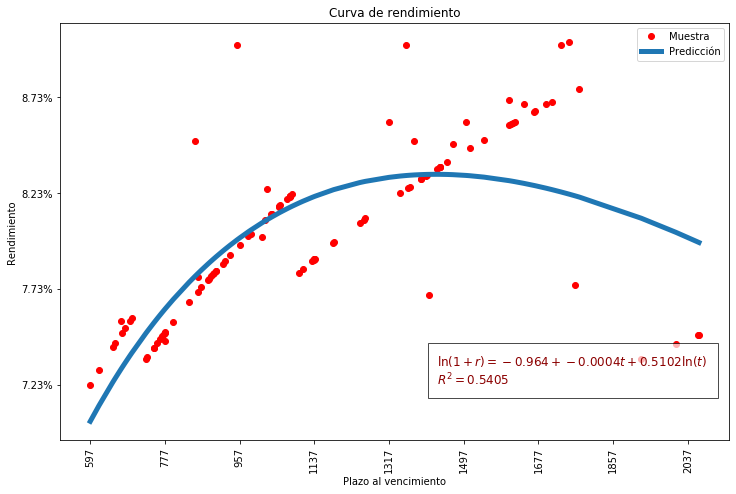

In [294]:
loglinlog(datos)

## Conclusiones

Si bien es cierto hemos demostrado, con una pequeña muestra, lo poderosa que puede ser esta herramienta para el análisis de datos financieros, sin embargo todo esto se ve un poco apañado dado los pobres resultados de ajuste en los modelos descritos. No es objeto de estudio de este trabajo responder los porques de esta situación, pero me atrevería a decir que el pobre desarrollo de nuestro mercado de valores hacen que existan estas inconsistencias de datos (tiempo vs rendimiento). Pues se debería encontrar consistencia dada la relación existente de riesgo, tiempo y rendimiento, donde las calificaciones de riesgos emitidas por los entes destinados para este efecto, deberian servir para homogeneizar este tipo de análisis, pero según por lo que se ve existen hasta 3 patrones/tendencias distintas o por lo menos traslapadas para instrumentos con "supuestamente" el mismo nivel de riesgo.